## Import statements

In [2]:
import meep as mp
import math
import cmath
import argparse
#import numpy as np
from IPython.display import Video
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.interpolate import interp1d
from autograd import grad
from autograd import numpy as np
import nlopt
#from tqdm.notebook import tqdm

Using MPI version 3.1, 1 processes


## Define materials

In [2]:
# epsilon from supplementary material of ilic et al for lambda = 610 nm, values confirmed on the site https://refractiveindex.info/

n_SiO2 = 1.46
n_Al2O3 = 1.68
n_Ta2O5 = 2.09
n_TiO2 = 2.35
SiO2 = mp.Medium(epsilon=n_SiO2**2)
Al2O3 = mp.Medium(epsilon=n_Al2O3**2)
Ta2O5 = mp.Medium(epsilon=n_Ta2O5**2)
TiO2 = mp.Medium(epsilon=n_TiO2**2)

## Set up quarter-wave (qw) stack parameters

In [3]:
# design qw stack to block wavelength of lambda_0 microns
lambda_0 = 1.2
fcen_0 = 1/lambda_0
print('Center frequency', fcen_0)

# set up qw stack
n_layers = 10
n1 = n_SiO2
n2 = n_TiO2
material1 = SiO2
material2 = TiO2
a = (n1+n2)/(4*n1*n2*fcen_0)
d1 = a*n2/(n1+n2)
d2 = a*n1/(n1+n2)

# Compute qw stack delta f
delta_f = fcen_0*(4/np.pi)*np.arcsin(np.abs(n1-n2)/(n1+n2))
print('Quarter wave gap size', delta_f)

Center frequency 0.8333333333333334
Quarter wave gap size 0.25016415689653043


In [19]:
a

0.33313902652287963

## Spectral reflectance and transmittance at normal incidence for quarter-wave stack of SiO2 and TiO2 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000357151 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
time for set_epsilon = 0.27153 s
-----------


<AxesSubplot:xlabel='X', ylabel='Y'>

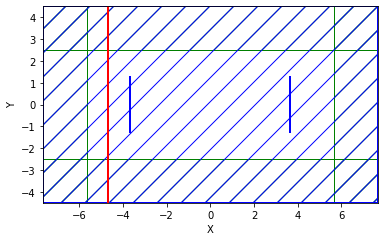

In [4]:
# Set up simulation for first run: no qw stack

resolution = 40     # pixels/um

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml)]

# pad up structure and make cell
pad = 4.
y_length = 5.
sx = n_layers*a + 2*dpml + 2*pad
sy = y_length + 2*dpml
cell = mp.Vector3(sx,sy)

# make geometry, no qw stack
geometry = []


# make a line of sources corresponding to normal incidence
# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.1
src_pos = -0.5*sx + dpml + pad/4
sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy)) ]

# make simulation object
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=mp.Vector3())

nf = 1
dft_vol = mp.Volume(center=mp.Vector3(0,0,0), size=cell)
dft_obj = sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez], fcen, df, nf, where=dft_vol, yee_grid=True)

# set up fluxes for reflected and transmitted flux
nfreq = 101
refl_pos = -0.5*sx + dpml + pad/2
refl_fr = mp.FluxRegion(center=mp.Vector3(refl_pos,0), size=mp.Vector3(0, y_length/2))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran_pos = 0.5*sx - dpml - pad/2
tran_fr = mp.FluxRegion(center=mp.Vector3(tran_pos,0), size=mp.Vector3(0,y_length/2,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Plot
sim.plot2D()

In [5]:
# Normalization run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
norm_refl_data = sim.get_flux_data(refl)
norm_tran_flux = mp.get_fluxes(tran)

on time step 1245 (time=15.5625), 0.00321425 s/step
on time step 2857 (time=35.7125), 0.00248272 s/step
field decay(t = 50.0125): 0.09987548842241936 / 0.09987548842241936 = 1.0
on time step 4650 (time=58.125), 0.0022315 s/step
on time step 6410 (time=80.125), 0.00227293 s/step
field decay(t = 100.025): 0.2460356599098966 / 0.2460356599098966 = 1.0
on time step 8219 (time=102.738), 0.00221206 s/step
on time step 9961 (time=124.513), 0.00229623 s/step
on time step 11733 (time=146.662), 0.0022583 s/step
field decay(t = 150.0375): 1.4238074362198705e-08 / 0.2460356599098966 = 5.786996229494938e-08
run 0 finished at t = 150.0375 (12003 timesteps)


In [6]:
ez = nf*[None]
for i in range(nf):
    ez[i] = sim.get_dft_array(dft_obj, mp.Ez, i)
dt = sim.fields.dt

In [10]:
ez[0][500, :]

array([2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.33418246+0.89432695j, 2.33418246+0.89432695j,
       2.3

-----------
Initializing structure...
time for choose_chunkdivision = 0.000504971 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

<AxesSubplot:xlabel='X', ylabel='Y'>

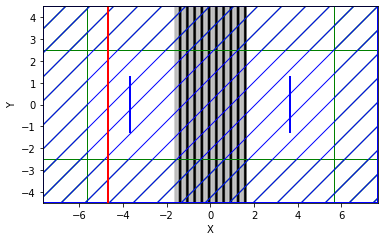

In [11]:
# Set up second simulation, with quarter-wave stack

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(d1, mp.inf),
                     center=mp.Vector3(d1/2 + i*a, 0),
                     material=material1) for i in range(-n_layers//2, n_layers//2)] + \
            [mp.Block(mp.Vector3(d2, mp.inf),
                     center=mp.Vector3(d1 + d2/2 + i*a, 0),
                     material=material2) for i in range(-n_layers//2, n_layers//2)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=mp.Vector3())

# Make new fluxes
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load negated fields from normalization run
sim.load_minus_flux_data(refl, norm_refl_data)
nf = 1
dft_vol = mp.Volume(center=mp.Vector3(0,0,0), size=cell)
dft_obj = sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez], fcen, df, nf, where=dft_vol, yee_grid=True)
# plot
sim.plot2D()

In [12]:
# Second run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
qw_refl_flux = mp.get_fluxes(refl)
qw_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

on time step 1702 (time=21.275), 0.00235151 s/step
on time step 3509 (time=43.8625), 0.00221449 s/step
field decay(t = 50.0125): 0.028789998691846633 / 0.028789998691846633 = 1.0
on time step 5282 (time=66.025), 0.00225668 s/step
on time step 7053 (time=88.1625), 0.00225968 s/step
field decay(t = 100.025): 0.10457806760557067 / 0.10457806760557067 = 1.0
on time step 8822 (time=110.275), 0.00226117 s/step
on time step 10572 (time=132.15), 0.00228611 s/step
field decay(t = 150.0375): 6.246886539128096e-09 / 0.10457806760557067 = 5.973419362355225e-08
run 0 finished at t = 150.0375 (12003 timesteps)


In [13]:
ez_2 = nf*[None]
for i in range(nf):
    ez_2[i] = sim.get_dft_array(dft_obj, mp.Ez, i)
dt = sim.fields.dt



In [17]:
ez_2[0][610, :]

array([0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.00050216-0.00045016j, 0.00050216-0.00045016j,
       0.0

In [153]:
Ts[50]

0.3680538290925158

In [154]:
Rs[50]

0.6319457428581853

In [155]:
Rs[50] - np.abs(ez_2[0][int(resolution*(dpml+pad/2)), 0] - ez[0][int(resolution*(dpml+pad/2)), 0])**2/np.abs(ez[0][int(resolution*(sx-dpml-pad/2)), 0])**2

-0.00014292439180729755

In [150]:
ez[0][int(resolution*(dpml+pad/2)), 0]

(2.069868431109729+1.4013827482589327j)

In [151]:
np.abs(ez_2[0][int(resolution*(sx-dpml-pad/2)), 0])**2/np.abs(ez[0][int(resolution*(sx-dpml-pad/2)), 0])**2

0.3679107941063187

In [152]:
ez[0][int(resolution*(sx-dpml-pad/2)), 0]

(1.7340783522670222+1.800333843849192j)

In [138]:
np.argwhere(np.abs(wl - 0.61018799)<.0001)

array([[49]])

0.36787836219763115

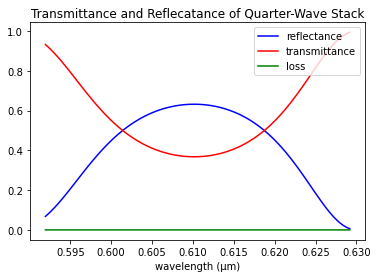

In [131]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-qw_refl_flux[i]/norm_tran_flux[i])
    Ts = np.append(Ts,qw_tran_flux[i]/norm_tran_flux[i])    
plt.figure()
plt.plot(wl,Rs,'b',label='reflectance')
plt.plot(wl,Ts,'r',label='transmittance')
plt.plot(wl,1-Rs-Ts,'g',label='loss')
plt.title('Transmittance and Reflecatance of Quarter-Wave Stack')
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000368118 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

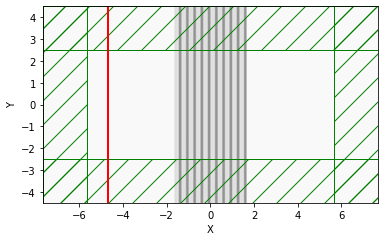

In [9]:
# Make Animation

animate = mp.Animate2D(sim, fields=mp.Ez, normalize=True)
sim.reset_meep()
sim.run(mp.at_every(1,animate),until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))

In [10]:
# Play animation

filename = "qw_stack.mp4"
fps = 10
animate.to_mp4(fps,filename)
Video(filename)

Generating MP4...


## Oblique incidence reflectance and transmittance of quarter-wave stack

### in 2 dimensions

In [173]:
# Define source at an angle

# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = .05*fcen
src_pos = -0.5*sx + dpml #+ pad/4
src_pt = mp.Vector3(src_pos, 0)

# Set theta incidence, compute k and the amplitude function
theta_in = np.pi/3
n0 = 1. # air
k = mp.Vector3(fcen*n0).rotate(mp.Vector3(z=1), theta_in)
def pw_amp(k,x0):
    def _pw_amp(x):
        return cmath.exp(1j*2*math.pi*k.dot(x+x0))
    return _pw_amp

sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy), 
                      amp_func=pw_amp(k,src_pt)) ]

In [174]:
k

Vector3<0.8196721311475412, 1.419713776695801, 0.0>

-----------
Initializing structure...
time for choose_chunkdivision = 6.48499e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
time for set_epsilon = 0.228256 s
-----------
Meep: using complex fields.


<AxesSubplot:xlabel='X', ylabel='Y'>

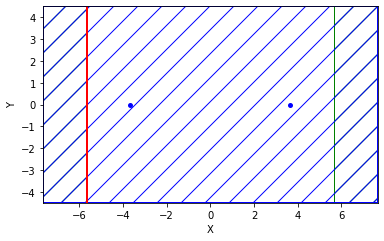

In [175]:
# Set up simulation for first run: no qw stack

resolution = 40     # pixels/um

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml, direction=mp.X)]

# pad up structure and make cell
pad = 4.
y_length = 5.
sx = n_layers*a + 2*dpml + 2*pad
sy = y_length + 2*dpml
cell = mp.Vector3(sx,sy)

# make geometry, no qw stack
geometry = []




# make simulation object
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# set up fluxes for reflected and transmitted flux
nfreq = 1
refl_pos = -0.5*sx + dpml + pad/2
refl_fr = mp.FluxRegion(center=mp.Vector3(refl_pos,0), size=mp.Vector3(0, 0), direction=mp.X)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran_pos = 0.5*sx - dpml - pad/2
tran_fr = mp.FluxRegion(center=mp.Vector3(tran_pos,0), size=mp.Vector3(0,0), direction=mp.X)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)
nf = 1
dft_vol = mp.Volume(center=mp.Vector3(0,0,0), size=cell)
dft_obj = sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez], fcen, df, nf, where=dft_vol, yee_grid=True)

# Plot
sim.plot2D()

In [176]:
# Normalization run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
norm_refl_data = sim.get_flux_data(refl)
norm_tran_flux = mp.get_fluxes(tran)

on time step 1148 (time=14.35), 0.00348469 s/step
on time step 2291 (time=28.6375), 0.0035015 s/step
on time step 3509 (time=43.8625), 0.00328502 s/step
field decay(t = 50.0125): 0.0012403395135396572 / 0.0012403395135396572 = 1.0
on time step 4683 (time=58.5375), 0.00340736 s/step
on time step 5839 (time=72.9875), 0.00346039 s/step
on time step 7058 (time=88.225), 0.00328537 s/step
field decay(t = 100.025): 0.9918305632808676 / 0.9918305632808676 = 1.0
on time step 8231 (time=102.888), 0.00341381 s/step
on time step 9381 (time=117.263), 0.00347905 s/step
on time step 10583 (time=132.287), 0.0033313 s/step
on time step 11776 (time=147.2), 0.00335343 s/step
field decay(t = 150.0375): 0.10088062285467829 / 0.9918305632808676 = 0.10171154891716198
on time step 12928 (time=161.6), 0.00347327 s/step
on time step 14132 (time=176.65), 0.00332338 s/step
on time step 15274 (time=190.925), 0.00350264 s/step
field decay(t = 200.05): 9.28607620270471e-13 / 0.9918305632808676 = 9.36256306922765e-13

In [177]:
ez = nf*[None]
for i in range(nf):
    ez[i] = sim.get_dft_array(dft_obj, mp.Ez, i)
dt = sim.fields.dt

In [178]:
ez

[array([[ 0.22029482-0.011154j  ,  0.21730644+0.03784355j,
          0.20355554+0.08496682j, ..., -0.07028484-0.20907956j,
         -0.02230342-0.21944653j,  0.02678262-0.218945j  ],
        [ 0.25237536+0.01941077j,  0.24183271+0.0747465j ,
          0.21931285+0.12638027j, ..., -0.04952923-0.24822763j,
          0.00659636-0.25303476j,  0.06239525-0.24530987j],
        [ 0.28715594+0.03902474j,  0.2714141 +0.10156698j,
          0.24222997+0.15907892j, ..., -0.04004663-0.28701521j,
          0.02442257-0.28876461j,  0.08768219-0.27621241j],
        ...,
        [-0.19502774-0.02426008j, -0.18483272-0.06679248j,
         -0.16548352-0.10601685j, ...,  0.02935929+0.1943255j ,
         -0.0143456 +0.19600656j, -0.05734   +0.18798003j],
        [-0.2082664 -0.07265898j, -0.18703944-0.11692078j,
         -0.15654901-0.15539186j, ..., -0.01365957+0.22015367j,
         -0.06201144+0.2116809j , -0.10729207+0.19272424j],
        [-0.22646877-0.1130575j , -0.19585635-0.1603446j ,
         -0.1

-----------
Initializing structure...
time for choose_chunkdivision = 0.000127077 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

<AxesSubplot:xlabel='X', ylabel='Y'>

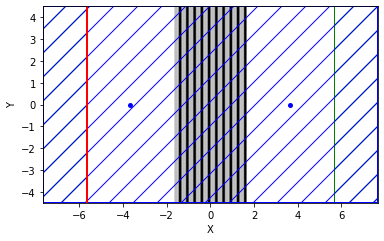

In [179]:
# Set up second simulation, with quarter-wave stack

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(d1, mp.inf),
                     center=mp.Vector3(d1/2 + i*a, 0),
                     material=material1) for i in range(-n_layers//2, n_layers//2)] + \
            [mp.Block(mp.Vector3(d2, mp.inf),
                     center=mp.Vector3(d1 + d2/2 + i*a, 0),
                     material=material2) for i in range(-n_layers//2, n_layers//2)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)


nf = 1
dft_vol = mp.Volume(center=mp.Vector3(0,0,0), size=cell)
dft_obj = sim.add_dft_fields([mp.Ex,mp.Ey,mp.Ez], fcen, df, nf, where=dft_vol, yee_grid=True)

# Make new fluxes
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load negated fields from normalization run
sim.load_minus_flux_data(refl, norm_refl_data)

# plot
sim.plot2D()

In [180]:
# Second run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
qw_refl_flux = mp.get_fluxes(refl)
qw_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

on time step 1112 (time=13.9), 0.00359861 s/step
on time step 2238 (time=27.975), 0.00355423 s/step
on time step 3386 (time=42.325), 0.00348708 s/step
field decay(t = 50.0125): 0.0004873890865204851 / 0.0004873890865204851 = 1.0
on time step 4551 (time=56.8875), 0.00343507 s/step
on time step 5741 (time=71.7625), 0.00336161 s/step
on time step 6907 (time=86.3375), 0.00343163 s/step
on time step 7927 (time=99.0875), 0.00392292 s/step
field decay(t = 100.025): 0.6761658769786744 / 0.6761658769786744 = 1.0
on time step 8990 (time=112.375), 0.00376354 s/step
on time step 10147 (time=126.838), 0.00345796 s/step
on time step 11285 (time=141.062), 0.00351612 s/step
field decay(t = 150.0375): 0.1555945014971506 / 0.6761658769786744 = 0.2301129157720834
on time step 12458 (time=155.725), 0.00341089 s/step
on time step 13634 (time=170.425), 0.00340275 s/step
on time step 14785 (time=184.812), 0.00347592 s/step
on time step 15943 (time=199.288), 0.00345648 s/step
field decay(t = 200.05): 1.110973

In [181]:
ez_2 = nf*[None]
for i in range(nf):
    ez_2[i] = sim.get_dft_array(dft_obj, mp.Ez, i)
dt = sim.fields.dt

In [182]:
np.abs(ez_2[0][int(resolution*(sx-dpml-pad/2)), 0])**2/np.abs(ez[0][int(resolution*(sx-dpml-pad/2)), 0])**2

0.7571192838662641

In [183]:
np.abs(ez_2[0][int(resolution*(dpml+pad/2)), 0] - ez[0][int(resolution*(dpml+pad/2)), 0])**2/np.abs(ez[0][int(resolution*(sx-dpml-pad/2)), 0])**2

0.24195738887388699

In [185]:
a = np.array([5,4,3])
a.shape[0]

3

In [ ]:
qw_refl

In [523]:
print('reflected flux', -qw_refl_flux[0]/norm_tran_flux[0])
print('transmitted flux', qw_tran_flux[0]/norm_tran_flux[0])

reflected flux 0.27905507222752624
transmitted flux 0.720944134920126


-----------
Initializing structure...
time for choose_chunkdivision = 9.29832e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

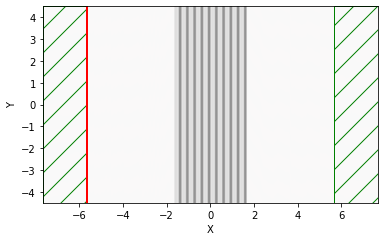

In [18]:
# Make Animation

animate = mp.Animate2D(sim, fields=mp.Ez, normalize=True)
sim.reset_meep()
sim.run(mp.at_every(1,animate),until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))

In [19]:
# Play Animation

filename = "qw_angle.mp4"
fps = 10
animate.to_mp4(fps,filename)
Video(filename)

Generating MP4...


### In 1-d

In [524]:
# Set up simulation for first run: no qw stack

resolution = 40     # pixels/um

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml)]

# pad up structure and make cell
pad = 4.
y_length = 0.
sx = n_layers*a + 2*dpml + 2*pad
sy = y_length
cell = mp.Vector3(sx)

# make geometry, no qw stack
geometry = []


# make a line of sources corresponding to normal incidence
# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.05 * fcen
src_pos = -0.5*sx + dpml + pad/4

# Define source at an angle

# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.1
src_pos = -0.5*sx + dpml #+ pad/4
src_pt = mp.Vector3(src_pos, 0)

# Set theta incidence, compute k and the amplitude function
theta_in = np.pi/6
n0 = 1. # air
k = mp.Vector3(fcen*n0).rotate(mp.Vector3(z=1), theta_in)
def pw_amp(k,x0):
    def _pw_amp(x):
        return cmath.exp(1j*2*math.pi*k.dot(x+x0))
    return _pw_amp

sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy), 
                      amp_func=pw_amp(k,src_pt)) ]

# make simulation object
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# set up fluxes for reflected and transmitted flux
nfreq = 1
refl_pos = -0.5*sx + dpml + pad/2
refl_fr = mp.FluxRegion(center=mp.Vector3(refl_pos,0), size=mp.Vector3(0, y_length/2))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran_pos = 0.5*sx - dpml - pad/2
tran_fr = mp.FluxRegion(center=mp.Vector3(tran_pos,0), size=mp.Vector3(0,y_length/2,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)


In [525]:
# Normalization run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
norm_refl_data = sim.get_flux_data(refl)
norm_tran_flux = mp.get_fluxes(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 8.2428e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 0.025 x 0 with resolution 40
time for set_epsilon = 0.00120673 s
-----------
Meep: using complex fields.
field decay(t = 50.0125): 0.0795574460017068 / 0.0795574460017068 = 1.0
field decay(t = 100.025): 0.3331643631258138 / 0.3331643631258138 = 1.0
field decay(t = 150.0375): 1.7033054509473342e-07 / 0.3331643631258138 = 5.112507937423398e-07
run 0 finished at t = 150.0375 (12003 timesteps)


In [526]:
# Set up second simulation, with quarter-wave stack

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(d1, mp.inf),
                     center=mp.Vector3(d1/2 + i*a, 0),
                     material=material1) for i in range(-n_layers//2, n_layers//2)] + \
            [mp.Block(mp.Vector3(d2, mp.inf),
                     center=mp.Vector3(d1 + d2/2 + i*a, 0),
                     material=material2) for i in range(-n_layers//2, n_layers//2)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# Make new fluxes
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load negated fields from normalization run
sim.load_minus_flux_data(refl, norm_refl_data)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000133923 s
Working in 2D dimensions.
Computational cell is 15.325 x 0.025 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (

In [527]:
# Second run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
qw_refl_flux = mp.get_fluxes(refl)
qw_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

field decay(t = 50.0125): 0.027508371286845055 / 0.027508371286845055 = 1.0
field decay(t = 100.025): 0.2436239079920462 / 0.2436239079920462 = 1.0
field decay(t = 150.0375): 8.00601790789084e-05 / 0.2436239079920462 = 0.00032862201308059714
field decay(t = 200.05): 6.437617215787138e-11 / 0.2436239079920462 = 2.6424406655513106e-10
run 0 finished at t = 200.05 (16004 timesteps)


In [528]:
print('reflected flux', -qw_refl_flux[0]/norm_tran_flux[0])
print('transmitted flux', qw_tran_flux[0]/norm_tran_flux[0])

reflected flux 0.27905510363380726
transmitted flux 0.720944157575216


## Reproduce figure 3 from Ilic et al: the reflectance heat map of the fabricated structure

### Visualize simulation setup

-----------
Initializing structure...
time for choose_chunkdivision = 0.0519772 s
Working in 2D dimensions.
Computational cell is 27.75 x 9 x 0 with resolution 40
     block, center = (-7.8635,0,0)
          size (0.018,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.3681,4.3681,4.3681)
     block, center = (-7.831,0,0)
          size (0.047,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-7.7295,0,0)
          size (0.156,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.3681,4.3681,4.3681)
     block, center = (-7.5455,0,0)
          size (0.212,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-7.3505,0,0)
          size (0.178,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          diele

<AxesSubplot:xlabel='X', ylabel='Y'>

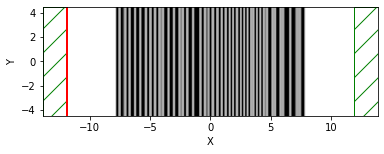

In [59]:
import meep as mp
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt

##############################################
# Set materials and structure specifications #
##############################################

# indices of refraction at 610 nm from supplementary material of ilic et al
# values validated on the site https://refractiveindex.info/
# for now, assume dispersionless materials
# TODO: check how good of an assumption that is
# in future iterations, use the values on that site for dispersion relations

n_SiO2 = 1.46
n_Al2O3 = 1.68
n_Ta2O5 = 2.09
n_TiO2 = 2.35
SiO2 = mp.Medium(epsilon=n_SiO2**2)
Al2O3 = mp.Medium(epsilon=n_Al2O3**2)
Ta2O5 = mp.Medium(epsilon=n_Ta2O5**2)
TiO2 = mp.Medium(epsilon=n_TiO2**2)

# material specifications
n1 = Ta2O5
n2 = SiO2
D = [18,47,156,212,178,23,51,224,150,205,258,187,243,190,266,215,153,227,154,226,152,245,24,
     229,263,190,257,200,260,224,27,229,154,219,274,198,405,211,166,233,47,66,17,125,153,
     237,151,225,147,193,127,214,135,173,112,165,130,223,130,163,112,164,114,167,121,378,114,
     160,113,174,117,211,23,221,261,399,266,390,28,18,367,198,302,28,33,426,31,15,222,96]
for i in range(len(D)):
    D[i] /= 1000 # convert from nm specifications to um

######################
# Set up simulations #
######################

resolution = 40 # pixels/um

# send in light with wavelength from 450 nm to 2250 nm
wvl_min = 0.450
wvl_max = 2.250
frq_min = 1/wvl_max
frq_max = 1/wvl_min
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
nfreq = 100

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml, direction=mp.X)]

# pad up structure and make the cell
pad = 4.
structure_length = sum(D)
y_length = 5.
sx = structure_length + 2*dpml + 2*pad
sy = y_length + 2*dpml
cell = mp.Vector3(sx,sy)

# make the geometry according to the specifications
geometry_no_stack = []
geometry_stack = [None]*len(D)
location_in_cell = -structure_length/2 
for i, element_width in enumerate(D):
    if i%2 == 0:
        material = Ta2O5
    else:
        material = SiO2
    geometry_stack[i] = mp.Block(mp.Vector3(element_width, mp.inf),
                                 center=mp.Vector3(location_in_cell + element_width/2, 0),
                                 material=material)
    location_in_cell += element_width

# set up the oblique-angle sources in parallel
src_pos = -0.5*sx + dpml
src_pt = mp.Vector3(src_pos, 0)
n_angles = 20
#n = mp.divide_parallel_processes(n_angles)
n = 10
n = n_angles - n
theta_in = n*np.pi/180
n0 = 1. # air
k = mp.Vector3(fcen*n0).rotate(mp.Vector3(z=1), theta_in)
def pw_amp(k,x0):
    def _pw_amp(x):
        return cmath.exp(1j*2*math.pi*k.dot(x+x0))
    return _pw_amp
sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy), 
                      amp_func=pw_amp(k,src_pt)) ]
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry_stack,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)
sim.plot2D()

### Visualize results

In [29]:
reflectances = []
for i in reversed(range(70)):
    single_angle_list = []
    for j in range(100):
        try:
            with open('./angle_by_angle_fixed_angles/back_fabricated_structure_reflectance_angle_'
                     +str(i) + '_wavelength_number_' + str(j) + '.npy', 'rb') as f:
                wavelength = np.load(f)
                reflectance = np.load(f)
            single_angle_list.append(reflectance[0])
        except:
            print(i)
            print(j)
            single_angle_list.append(-1)
    reflectances.append(single_angle_list)
    print('Progress:', i, ' of 70')

69
15
69
16
69
17
69
18
69
19
69
20
69
21
69
22
69
23
69
24
69
25
69
26
69
27
69
28
69
29
69
30
69
31
69
32
69
33
69
34
69
35
69
36
69
37
69
38
69
39
69
40
69
41
69
42
69
43
69
44
69
45
69
46
69
47
69
48
69
49
69
50
69
51
69
52
69
53
69
54
69
55
69
56
69
57
69
58
69
59
69
60
69
61
69
62
69
63
69
64
69
65
69
66
69
67
69
68
69
69
69
70
69
71
69
72
69
73
69
74
69
75
69
76
69
77
69
78
69
79
69
80
69
81
69
82
69
83
69
84
69
85
69
86
69
87
69
88
69
89
69
90
69
91
69
92
69
93
69
94
69
95
69
96
69
97
69
98
69
99
Progress: 69  of 70
Progress: 68  of 70
Progress: 67  of 70
Progress: 66  of 70
Progress: 65  of 70
Progress: 64  of 70
Progress: 63  of 70
Progress: 62  of 70
Progress: 61  of 70
Progress: 60  of 70
Progress: 59  of 70
Progress: 58  of 70
Progress: 57  of 70
Progress: 56  of 70
Progress: 55  of 70
Progress: 54  of 70
Progress: 53  of 70
Progress: 52  of 70
Progress: 51  of 70
Progress: 50  of 70
Progress: 49  of 70
Progress: 48  of 70
Progress: 47  of 70
Progress: 46  of 70
Progress: 

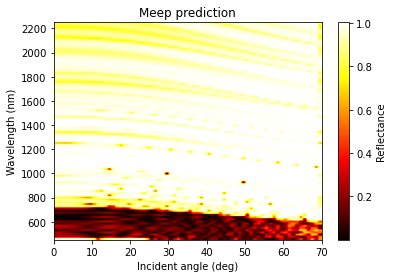

In [65]:
for i in range(len(reflectances)):
    for j in range(len(reflectances[0])):
        if reflectances[i][j] == -1:
            reflectances[i][j] = reflectances[i-1][j]
reflectances = np.array(reflectances)
#reflectances[13, 0] = 1
plt.imshow(np.flip(np.flip(reflectances.T, axis=0),axis=1), cmap='hot', extent=[0, 70, 450, 2250], aspect='auto')
plt.xlabel('Incident angle (deg)')
plt.ylabel('Wavelength (nm)')
plt.title('Meep prediction')
cb = plt.colorbar()
cb.set_label('Reflectance')

In [64]:
fabricated_reflectance = np.zeros((len(reflectances), len(reflectances[0])))
for i in range(len(reflectances)):
    for j in range(len(reflectances[0])):
        fabricated_reflectance[i,j] = reflectances[i][j]
with open('save_fabricated_reflectance.npy', 'wb') as f:
    np.save(f, fabricated_reflectance)

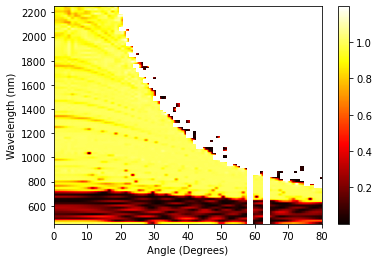

In [6]:
reflectances_all = []
for i in range(80):
    try:
        with open('./angle_by_angle_compute/fabricated_structure_reflectance_one_angle_' 
                  + str(i) + '.npy', 'rb') as f:
            wavelengths = np.load(f)
            reflectances = np.load(f)
        reflectances_all.append(reflectances)
    except:
        reflectances_all.append(None)
for i in range(80):
    if reflectances_all[i] is None:
        
        if reflectances_all[i+1] is not None:
            reflectances_all[i] = (reflectances_all[i-1] + reflectances_all[i+1])/2
        else:
            reflectances_all[i] = reflectances_all[i-1]
        reflectances_all[i] = -1*np.ones(100)
reflectances_all = np.stack(reflectances_all)
lower_bound = 0
upper_bound = 1.2
reflectances_all = np.ma.masked_where((lower_bound > reflectances_all) | 
                                      (upper_bound < reflectances_all), reflectances_all)
plt.imshow(np.flip(reflectances_all, axis=1).T, cmap='hot', extent=[0,80,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

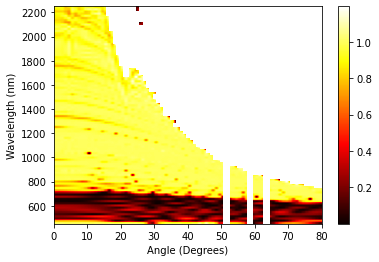

In [204]:
reflectances_all = []
for i in range(80):
    try:
        with open('./angle_by_angle_compute/back_fabricated_structure_reflectance_one_angle_' 
                  + str(i) + '.npy', 'rb') as f:
            wavelengths = np.load(f)
            reflectances = np.load(f)
        reflectances_all.append(reflectances)
    except:
        reflectances_all.append(None)
for i in range(80):
    if reflectances_all[i] is None:
        
        if i+1 < 80 and reflectances_all[i+1] is not None:
            reflectances_all[i] = (reflectances_all[i-1] + reflectances_all[i+1])/2
        else:
            reflectances_all[i] = reflectances_all[i-1]
        reflectances_all[i] = -1*np.ones(100)
reflectances_all = np.stack(reflectances_all)
lower_bound = 0
upper_bound = 1.2
reflectances_all = np.ma.masked_where((lower_bound > reflectances_all) | 
                                      (upper_bound < reflectances_all), reflectances_all)
plt.imshow(np.flip(reflectances_all, axis=1).T, cmap='hot', extent=[0,80,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

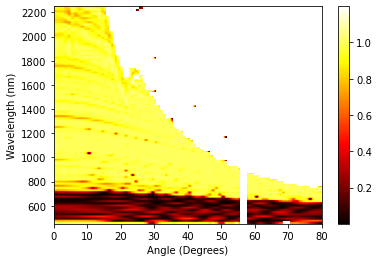

In [7]:
reflectances_all = []
for i in range(80):
    try:
        with open('./angle_by_angle_compute/back_fabricated_structure_reflectance_one_angle_doubled_pml_' 
                  + str(i) + '.npy', 'rb') as f:
            wavelengths = np.load(f)
            reflectances = np.load(f)
        reflectances_all.append(reflectances)
    except:
        reflectances_all.append(None)
for i in range(80):
    if reflectances_all[i] is None:
        
        if i+1 < 80 and reflectances_all[i+1] is not None:
            reflectances_all[i] = (reflectances_all[i-1] + reflectances_all[i+1])/2
        else:
            reflectances_all[i] = reflectances_all[i-1]
        reflectances_all[i] = -1*np.ones(100)
reflectances_all = np.stack(reflectances_all)
lower_bound = 0
upper_bound = 1.2
reflectances_all = np.ma.masked_where((lower_bound > reflectances_all) | 
                                      (upper_bound < reflectances_all), reflectances_all)
plt.imshow(np.flip(reflectances_all, axis=1).T, cmap='hot', extent=[0,80,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

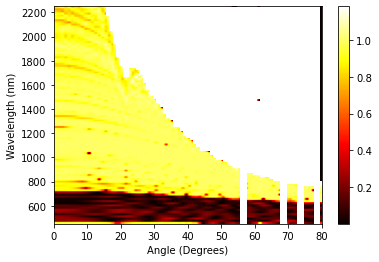

In [94]:
reflectances_all = []
for i in range(80):
    try:
        with open('./angle_by_angle_compute/back_fabricated_structure_reflectance_one_angle_doubled_pml_and_res_' 
                  + str(i) + '.npy', 'rb') as f:
            wavelengths = np.load(f)
            reflectances = np.load(f)
            stack_refl_flux = np.load(f)
            norm_tran_flux = np.load(f)
        reflectances_all.append(reflectances)
    except:
        reflectances_all.append(None)
for i in range(80):
    if reflectances_all[i] is None:
        
        if i+1 < 80 and reflectances_all[i+1] is not None:
            reflectances_all[i] = (reflectances_all[i-1] + reflectances_all[i+1])/2
        else:
            reflectances_all[i] = reflectances_all[i-1]
        reflectances_all[i] = -1*np.ones(100)
reflectances_all = np.stack(reflectances_all)
lower_bound = 0
upper_bound = 1.2
reflectances_all = np.ma.masked_where((lower_bound > reflectances_all) | 
                                      (upper_bound < reflectances_all), reflectances_all)
plt.imshow(np.flip(reflectances_all, axis=1).T, cmap='hot', extent=[0,80,450,2250], aspect='auto')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Wavelength (nm)')
plt.colorbar()

## Luminosity efficiency function of wavelength

In [50]:
luminosity_data = np.genfromtxt('luminosity_efficiency.csv', delimiter=',')
luminosity_data.shape

(4401, 2)

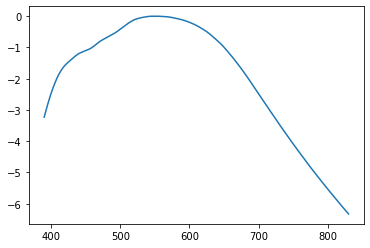

In [51]:
plt.plot(luminosity_data[:, 0], luminosity_data[:, 1])

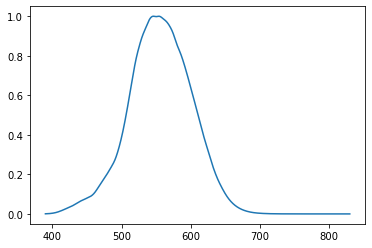

In [52]:
plt.plot(luminosity_data[:, 0], 10**luminosity_data[:, 1])

In [53]:
log10_luminosity = interp1d(luminosity_data[:,0], luminosity_data[:,1])

In [54]:
log10_luminosity(390.11)

array(-3.219941)

In [55]:
def luminosity(lam):
    # takes in wavelength in microns
    try:
        lam = lam*1000
        return 10**log10_luminosity(lam)
    except:
        return 0

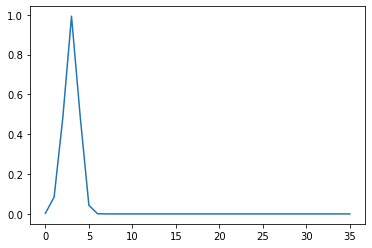

In [56]:
wvls = np.linspace(0.4, 2.25, 36)
lum_func = []
for wvl in wvls:
    lum_func.append(luminosity(wvl))
plt.plot(lum_func)

In [57]:
lum_func = np.array(lum_func)

In [38]:
np.trapz(lum_func**2)/np.trapz(lum_func)

0.7000000242478573

In [39]:
with open('needle_optimized/save_luminosity_function.npy', 'wb') as f:
    np.save(f, lum_func)

## Tungsten emittance function of wavelength and angle at 3000 K

### Normal incidence

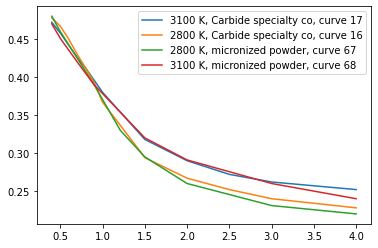

In [140]:
# Use linear interpolation to find emittance at wavelength 3000 K

# curve 17, 3100 K
data_17 = np.array([[0.4, .472], [.5, .458],[.6,.442],[.7,.426],[.8,.412],[.9,.396],[1,.38], [1.5,.318], 
                    [2, .290], [2.5, .272], [3, .262], [4, .252]])
plt.plot(data_17[:, 0], data_17[:, 1], label='3100 K, Carbide specialty co, curve 17')

# curve 16, 2800 K
data_16 = np.array([[0.4, .478], [.5, .467],[.6,.450],[.7,.430],[.8,.412],[.9,.393],[1,.367], [1.42,.306],
                    [1.5,.294], [2, .267], [2.5, .252], [3, .240], [4, .228]])
plt.plot(data_16[:, 0], data_16[:, 1], label='2800 K, Carbide specialty co, curve 16')

# curve 24, 2800 K, tungsten balance of mix
data_24 = np.array([[.25, .41], [.27,.445], [.3,.456], [.32,.457], [.35, .461], [.37,.463], [.40,.461],
                   [.45, .454], [.5, .448], [.55, .443], [.6, .434], [.65, .427], [.7, .419], [.75,.41],
                   [.8, .4], [.9,.373], [1, .367], [1.2, .367], [1.2, .337], [1.32, .328], [1.35, .318],
                   [1.5, .302], [1.6, .292], [1.8, .274], [2.4, .233], [2.6, .224]])
#plt.plot(data_24[:, 0], data_24[:, 1], label='2800 K, mixture, curve 24')

# curve 67, micronized
data_67 = np.array([[0.4, .48], [.5, .46],[.7,.425],[.9,.39],[1.21,.33],
                    [1.5,.295], [2, .260], [3, .231], [4, .22]])
plt.plot(data_67[:, 0], data_67[:, 1], label='2800 K, micronized powder, curve 67')

# curve 68, micronized
data_67 = np.array([[0.4, .47], [.5, .451],[.7,.420],[.9,.39],
                    [1.5,.32], [2, .291], [3, .26], [4, .24]])
plt.plot(data_67[:, 0], data_67[:, 1], label='3100 K, micronized powder, curve 68')

plt.legend()

In [46]:
# we'll interpolate curves 17 and 16 and interpolate 3000 K linearly from 2800 and 3100 K

emittance_2800 = interp1d(data_16[:, 0], data_16[:, 1])
emittance_3100 = interp1d(data_17[:, 0], data_17[:, 1])

def emittance_3000(wvl):
    return (2*emittance_2800(wvl) + emittance_3100(wvl))/3

Text(0, 0.5, 'normal spectral emittance')

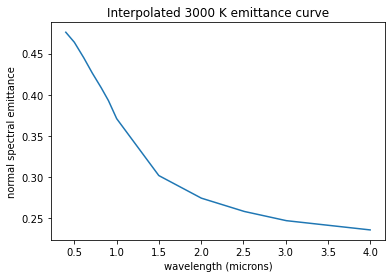

In [47]:
x = np.linspace(.4, 4, 1000)
plt.plot(x, emittance_3000(x))
plt.title('Interpolated 3000 K emittance curve')
plt.xlabel('wavelength (microns)')
plt.ylabel('normal spectral emittance')

Text(0, 0.5, 'normal spectral emittance')

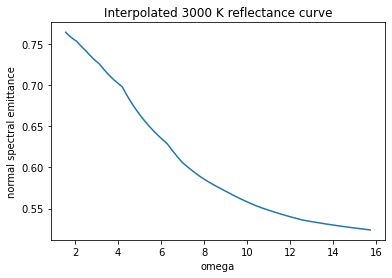

In [48]:
x = np.linspace(.4, 4, 1000)
plt.plot(2*np.pi/x, 1 - emittance_3000(x))
plt.title('Interpolated 3000 K reflectance curve')
plt.xlabel('omega')
plt.ylabel('normal spectral emittance')

### Incidence at an angle

In [49]:
# Fit emittance/absorptivity to a drude-lorentzian function in the metal limit

T = 3000

# planck's natural units
c = k = 1
h = 2 * np.pi

emittance = absorptivity = emittance_3000
wavelengths = np.linspace(0.4, .8, num=50)
omega = 2*np.pi/wavelengths
material_absorption = absorptivity(wavelengths)

actual_power_reflectance = 1 - material_absorption

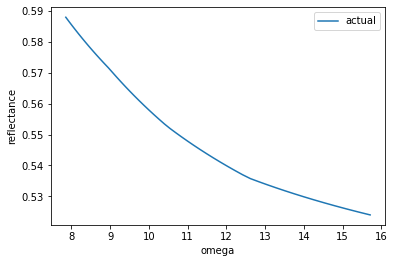

In [50]:
plt.plot(omega, actual_power_reflectance, label='actual')
#plt.plot(omega, modeled_power_reflectance, label='modeled')
#plt.ylim(0, 1)
plt.xlabel('omega')
plt.ylabel('reflectance')
plt.legend()

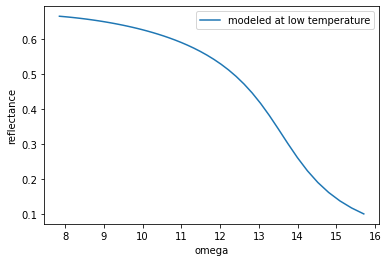

In [51]:
# drude-lorentzian of low-temp W
f = [.275, .006, .19, .75, 2.38]
gamma = [.05, .72, 1.33, 2.44, 2.8]
omega_p = 13.22
Omega_p = np.sqrt(f[0])*omega_p
omega_j = [float('inf'), .94, 1.86, 3.35, 7.70]

#f = [.206, .706,2.590]
#gamma = [.206, 3.332, 5.836]
#omega_j = [float('inf'), 3.580, 7.498]

drude_model = 1 - f[0]*Omega_p**2/(omega*(omega-1j*gamma[0]))
lorentz_result = sum([f[i]*omega_p**2/(omega_j[i]**2 - omega**2 + 1j * omega * gamma[i]) 
                     for i in range(1, len(f) - 1)])

eps = drude_model + lorentz_result
n = np.sqrt(eps)
modeled_power_reflectance = np.abs((1 - n)/(1 + n))**2
#plt.plot(omega, actual_power_reflectance, label='actual')
plt.plot(omega, modeled_power_reflectance, label='modeled at low temperature')
#plt.ylim(0, 1)
plt.xlabel('omega')
plt.ylabel('reflectance')
plt.legend()

In [52]:
hbar*16.585*10**14/e

1.0922081772784018

[0.275 0.06  0.19  0.75  2.39 ]
[       inf 0.888517   1.83451968 3.33592003 7.69388474]
[1.36792545 2.03792545 2.64792545 3.75792545 4.11792545]


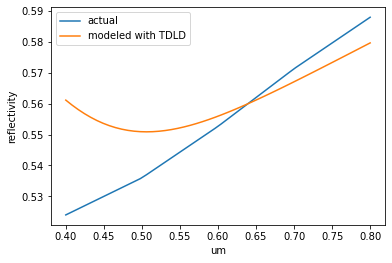

In [53]:
# use TDLD model to get the first curve 
# https://www.fresnel.fr/perso/gallais/Minissale%20et%20al.%20-%202017%20-%20J.%20Phys.%20D%20-%20vol.%2050%20p%20455601.pdf

T = 3000
T_room = 293
c = 2.998e8
hbar = 1.055e-34
e = 1.602e-19

wavelengths = np.linspace(.4, .8, 50) 
omega = (2*np.pi*c*hbar/(wavelengths*1e-6))/e

f = np.array([.275, .06, .19, .75, 2.39])
gamma = np.array([.05, .72, 1.33, 2.44, 2.8])


#gamma = np.array([.064, .53, 1.281, 3.332, 5.836])
#f = np.array([.206, .054, .166, .706, 2.509])

omega_p = 13.22
#Omega_p = np.sqrt(f[0])*omega_p
omega_j = np.array([float('inf'), .94, 1.86, 3.35, 7.70])


#omega_j = np.array([float('inf'), 1.004, 1.917, 3.580, 7.498])

alpha = 3.5e-2
beta = 2.5e-3
gam = 4.3e-6
gamma = gamma + alpha*(np.sqrt(T) - np.sqrt(T_room))
omega_j = np.sqrt(omega_j**2 - beta * (np.sqrt(T) - np.sqrt(T_room)))
omega_p = omega_p/(np.sqrt(1+gam*(T-T_room)))


#gamma[0] = 2.

print(f)
print(omega_j)
print(gamma)

drude_model = 1 - f[0]*omega_p**2/(omega*(omega-1j*gamma[0]))
lorentz_result = sum([f[i]*omega_p**2/(omega_j[i]**2 - omega**2 + 1j * omega * gamma[i]) 
                     for i in range(1, len(f) - 1)])

eps = drude_model + lorentz_result
n = np.sqrt(eps)
modeled_power_reflectance = np.abs((1 - n)/(1 + n))**2
plt.plot(wavelengths, actual_power_reflectance, label='actual')
plt.plot(wavelengths, modeled_power_reflectance, label='modeled with TDLD')
#plt.ylim(0.5, .65)
plt.xlabel('um')
plt.ylabel('reflectivity')
plt.legend()
plt.show()

In [54]:
def eps(wvl):
    '''
    given wvl in microns, computes eps
    '''
    c = 2.998e8
    hbar = 1.055e-34
    e = 1.602e-19
    omega = (2*np.pi*c*hbar/(wvl*1e-6))/e
    f = [0.275, 0.06,  0.19,  0.75,  2.39 ]
    omega_j = [       'inf', 0.888517,   1.83451968, 3.33592003, 7.69388474]
    gamma = [1.36792545, 2.03792545, 2.64792545, 3.75792545, 4.11792545]
    drude_model = 1 - f[0]*omega_p**2/(omega*(omega-1j*gamma[0]))
    lorentz_result = sum([f[i]*omega_p**2/(omega_j[i]**2 - omega**2 + 1j * omega * gamma[i]) 
                     for i in range(1, len(f) - 1)])

    eps = drude_model + lorentz_result
    return eps

### Optimized curve fitting

In [141]:
# gradient descent curve fitting

c = 2.998e8
hbar = 1.055e-34
e = 1.602e-19
wavelengths = np.linspace(.4, .8)
omega = (2*np.pi*c*hbar/(wavelengths*1e-6))/e
f = [0.275, 0.06,  0.19,  0.75,  2.39 ]
omega_j = [       'inf', 0.888517,   1.83451968, 3.33592003, 7.69388474]
gamma = [1.36792545, 2.03792545, 2.64792545, 3.75792545, 4.11792545]
omega_p = 13.22

w_init = np.array(f + gamma + omega_j[1:] + [omega_p])

def model_reflectance(w):
    f = w[:5]
    omega_p = w[-1]
    omega_j = np.concatenate(([-1], w[10:14]))
    gamma = w[5:10]
    drude_model = 1 - f[0]*omega_p**2/(omega*(omega-1j*gamma[0]))
    lorentz_result = sum([f[i]*omega_p**2/(omega_j[i]**2 - omega**2 + 1j * omega * gamma[i]) 
                     for i in range(1, len(f) - 1)])

    eps = drude_model + lorentz_result
    n = np.sqrt(eps)
    modeled_power_reflectance = np.abs((1 - n)/(1 + n))**2
    return modeled_power_reflectance

def loss_from_fit(w):
    modeled_power_reflectance = model_reflectance(w)
    return np.sum(np.abs((modeled_power_reflectance - actual_power_reflectance)/actual_power_reflectance))

loss_grad = grad(loss_from_fit)


def myfunc(x, grad):
    loss = loss_from_fit(x)
    if grad.size > 0:
        grad[:] = loss_grad(x)
    print('loss', loss)
    return loss

In [66]:
opt = nlopt.opt(nlopt.GN_DIRECT_L, 15)
opt.set_lower_bounds([0 for i in range(15)])
opt.set_upper_bounds([20 for i in range(15)])
opt.set_min_objective(myfunc)
opt.set_maxeval(9000)
w = opt.optimize(w_init)

loss 8.065159677484106
loss 2.2016248721387246
loss 14.527333847231013
loss 8.153235511402876
loss 8.248609426165546
loss 8.153235511402876
loss 8.248609426165546
loss 8.153235511402876
loss 8.248609426165547
loss 8.065159677484106
loss 8.065159677484106
loss 21.97440295398409
loss 2.659831982246026
loss 7.619316971576046
loss 8.434318055747896
loss 7.619316971576046
loss 8.434318055747896
loss 7.619316971576046
loss 8.434318055747896
loss 8.065159677484106
loss 8.065159677484106
loss 15.281890978281314
loss 7.974788368538667
loss 15.281890978281314
loss 7.974788368538667
loss 15.281890978281314
loss 7.974788368538667
loss 8.065159677484106
loss 8.065159677484106
loss 26.0402610348894
loss 19.296479740396993
loss 4.4602393174907915
loss 1.160882131076518
loss 4.4602393174907915
loss 1.160882131076518
loss 4.4602393174907915
loss 1.1608821310765176
loss 2.2016248721387246
loss 2.2016248721387246
loss 5.540973116945233
loss 3.780737410357063
loss 2.64620548516508
loss 1.9243635598971864


loss 1.5588930368145493
loss 1.7366362397202753
loss 2.1282290030409245
loss 1.9424069561321802
loss 6.082418777924463
loss 1.6123552251690363
loss 16.06684660084048
loss 1.6004761950502675
loss 6.955154596160124
loss 2.27891346249475
loss 10.713225511204348
loss 4.0482395612173425
loss 34.15336736813715
loss 13.330827712634886
loss 1.8346586226082016
loss 1.710100625267521
loss 0.22660455505175472
loss 0.2880431331796747
loss 0.22996001462998433
loss 0.2876695278504764
loss 0.27425475177509395
loss 0.3266091397003453
loss 0.2527450303185682
loss 0.2527450303185682
loss 0.23668274432731237
loss 0.2717007519983169
loss 0.24986839302367964
loss 0.2556546460914737
loss 0.2595481996574187
loss 0.24879348701754492
loss 0.2527450303185682
loss 0.2527450303185682
loss 0.8599563730006672
loss 0.8673821635701063
loss 0.2527450303185682
loss 0.2527450303185682
loss 2.3846414312453783
loss 1.9998806884223461
loss 3.8511211772963927
loss 4.256007848643271
loss 0.5464772707203296
loss 0.65017372969

loss 0.21096421484642983
loss 2.455328190788905
loss 1.9340454481294704
loss 1.5588930368145493
loss 1.7366362397202753
loss 2.1282290030409245
loss 1.9424069561321802
loss 6.082418777924463
loss 1.6123552251690363
loss 16.06684660084048
loss 1.6004761950502675
loss 6.955154596160124
loss 2.27891346249475
loss 10.713225511204348
loss 4.0482395612173425
loss 34.15336736813715
loss 13.330827712634886
loss 0.26631185151569153
loss 0.1850715128440341
loss 0.13577760741481049
loss 0.13672554646857282
loss 0.13619139882282558
loss 0.1365594264541481
loss 0.13683965886379215
loss 0.1369297471187832
loss 0.13605982197862662
loss 0.13605982197862662
loss 0.12992110287625247
loss 0.16222577839828503
loss 0.13632473846355084
loss 0.1361115497781966
loss 0.13607529904514937
loss 0.1360695679412196
loss 0.1364880118187904
loss 0.13589198560308163
loss 0.13605982197862662
loss 0.13605982197862662
loss 0.1371839766099682
loss 0.13578120353260306
loss 0.1368500516679223
loss 0.13685837226151484
loss 0

loss 0.33882280312374397
loss 0.2692116322858328
loss 0.79586002134339
loss 0.9405942250736472
loss 2.455328190788905
loss 1.9340454481294704
loss 1.8901684504328797
loss 1.6841272797798947
loss 2.2262103174686767
loss 1.7985938391448788
loss 5.599214764660099
loss 1.686536924959974
loss 15.983234271391144
loss 1.925003748793592
loss 10.376941391525108
loss 2.3445852751230127
loss 10.416158893240832
loss 4.362860285449765
loss 1.0663114031360506
loss 1.0663114031360506
loss 34.29996165386289
loss 13.182188068403482
loss 0.253923026867402
loss 0.21142753372429254
loss 0.1211576459153052
loss 0.12154551695086417
loss 0.12050826859193292
loss 0.12050826859193292
loss 0.12050826859193292
loss 0.12050826859193292
loss 0.12050826859193292
loss 0.12050826859193292
loss 0.27066586722744645
loss 0.21605980660703283
loss 0.7107673463983514
loss 0.6211762671751045
loss 0.1430743954728087
loss 0.14372717044622424
loss 0.13723485156542511
loss 0.1362146501727175
loss 0.13636017038077708
loss 0.1360

loss 0.12154551695086417
loss 0.27066586722744645
loss 0.21605980660703283
loss 0.7107673463983514
loss 0.6211762671751045
loss 0.1430743954728087
loss 0.14372717044622424
loss 0.13723485156542511
loss 0.1362146501727175
loss 0.13636017038077708
loss 0.13608855127981104
loss 0.2703650627330612
loss 0.3210428591706292
loss 0.7858297144166029
loss 0.672518436723892
loss 1.9744463694861325
loss 1.698460202264218
loss 0.2442787632695043
loss 0.2341975033913397
loss 0.33882280312374397
loss 0.2692116322858328
loss 0.79586002134339
loss 0.9405942250736472
loss 2.455328190788905
loss 1.9340454481294704
loss 1.8901684504328797
loss 1.6841272797798947
loss 2.2262103174686767
loss 1.7985938391448788
loss 5.599214764660099
loss 1.686536924959974
loss 15.983234271391144
loss 1.925003748793592
loss 10.376941391525108
loss 2.3445852751230127
loss 10.416158893240832
loss 4.362860285449765
loss 1.0663114031360506
loss 1.0663114031360506
loss 34.29996165386289
loss 13.182188068403482
loss 0.13259579814

loss 0.11614108051234147
loss 0.253923026867402
loss 0.21142753372429254
loss 0.1211576459153052
loss 0.12154551695086417
loss 0.27066586722744645
loss 0.21605980660703283
loss 0.7049647693934867
loss 0.6272111822466294
loss 0.14153755103112958
loss 0.14497318907702098
loss 0.13674774953220237
loss 0.13634725733485675
loss 0.27482234611712897
loss 0.3149589187256227
loss 0.7798354937858052
loss 0.678405137377244
loss 1.9904908344093233
loss 1.679411391442249
loss 0.25784617894246387
loss 0.23014388397161867
loss 0.35760850235678643
loss 0.2636024193241124
loss 0.7788668493902472
loss 0.9600486534848347
loss 0.2141820702078424
loss 0.2141820702078424
loss 2.4739668972029345
loss 1.9163803691698844
loss 1.8901684504328797
loss 1.6841272797798947
loss 2.2262103174686767
loss 1.7985938391448788
loss 5.599214764660099
loss 1.686536924959974
loss 15.983234271391144
loss 1.925003748793592
loss 10.376941391525108
loss 2.3445852751230127
loss 10.416158893240832
loss 4.362860285449765
loss 34.29

loss 0.21142753372429254
loss 0.1211576459153052
loss 0.12154551695086417
loss 0.27066586722744645
loss 0.21605980660703283
loss 0.7049647693934867
loss 0.6272111822466294
loss 0.14153755103112958
loss 0.14497318907702098
loss 0.13674774953220237
loss 0.13634725733485675
loss 0.27482234611712897
loss 0.3149589187256227
loss 0.7798354937858052
loss 0.678405137377244
loss 1.9904908344093233
loss 1.679411391442249
loss 0.25784617894246387
loss 0.23014388397161867
loss 0.35760850235678643
loss 0.2636024193241124
loss 0.7788668493902472
loss 0.9600486534848347
loss 2.4739668972029345
loss 1.9163803691698844
loss 2.2262103174686767
loss 1.7985938391448788
loss 1.8901684504328797
loss 1.6841272797798947
loss 5.599214764660099
loss 1.686536924959974
loss 10.376941391525108
loss 2.3445852751230127
loss 15.983234271391144
loss 1.925003748793592
loss 10.416158893240832
loss 4.362860285449765
loss 1.0663114031360506
loss 1.0663114031360506
loss 34.29996165386289
loss 13.182188068403482
loss 0.1132

loss 0.11297990936616267
loss 0.11295943563499417
loss 0.11298749382559041
loss 0.11297346481843076
loss 0.11297346481843076
loss 0.11293439302483854
loss 0.11301253624544177
loss 0.11297222090404609
loss 0.11297470878234424
loss 0.11297210422463343
loss 0.11297482542186282
loss 0.11296685958808848
loss 0.11298006978508218
loss 0.11297346481843076
loss 0.11297346481843076
loss 0.11298273864973378
loss 0.1129641940302884
loss 0.11298685794912106
loss 0.11296007600001307
loss 0.11304559578019457
loss 0.11290134876315856
loss 0.11297346481843076
loss 0.11297346481843076
loss 0.11292774055566622
loss 0.11301918460245702
loss 0.11297346481843076
loss 0.11297346481843076
loss 0.11297346481843076
loss 0.11297346481843076
loss 0.7049647693934867
loss 0.6272111822466294
loss 0.14153755103112958
loss 0.14497318907702098
loss 0.13674774953220237
loss 0.13634725733485675
loss 0.27482234611712897
loss 0.3149589187256227
loss 0.7798354937858052
loss 0.678405137377244
loss 1.9529096483660284
loss 1.7

loss 2.4374789012863634
loss 1.9508938214407954
loss 2.2262103174686767
loss 1.7985938391448788
loss 1.8901684504328797
loss 1.6841272797798947
loss 5.599214764660099
loss 1.686536924959974
loss 10.376941391525108
loss 2.3445852751230127
loss 15.983234271391144
loss 1.925003748793592
loss 10.416158893240832
loss 4.362860285449765
loss 34.29996165386289
loss 13.182188068403482
loss 0.11272444899706648
loss 0.11272444899706648
loss 0.11272320497827457
loss 0.11272569306541907
loss 0.112723087945492
loss 0.1127258100583243
loss 0.11272444899706648
loss 0.11272444899706648
loss 0.11272444899706648
loss 0.11272444899706648
loss 0.6939536380642508
loss 0.6375490728170599
loss 0.1390974471474115
loss 0.14789793650172406
loss 0.2836407774875384
loss 0.30401406399152137
loss 0.7690486503850449
loss 0.6889915004765872
loss 1.9529096483660284
loss 1.7119512832844046
loss 0.2322721223004967
loss 0.24486719731548928
loss 0.3213116779565347
loss 0.2815946545706312
loss 0.8117697590921025
loss 0.9220

loss 0.3213116779565347
loss 0.2815946545706312
loss 0.8117697590921025
loss 0.9220426741370861
loss 2.4374789012863634
loss 1.9508938214407954
loss 2.389096228060346
loss 1.546624801779351
loss 2.389096228060346
loss 1.546624801779351
loss 5.017087637148107
loss 1.7895922833736728
loss 15.869071314403325
loss 2.417355111025311
loss 15.869071314403325
loss 2.417355111025311
loss 10.058818943410829
loss 4.866671564077028
loss 1.0811104857961087
loss 1.0811104857961087
loss 34.5718575001726
loss 12.922085728385278
loss 0.1126432312281651
loss 0.11264722329498984
loss 0.11264308139152104
loss 0.11264737310934296
loss 0.11264522724611392
loss 0.11264522724611392
loss 0.11264481256161933
loss 0.1126456419361112
loss 0.11264477350395304
loss 0.11264568098935789
loss 0.11264302310902004
loss 0.11264743135393081
loss 0.11264522724611392
loss 0.11264522724611392
loss 0.11264522724611392
loss 0.11264522724611392
loss 0.6939536380642508
loss 0.6375490728170599
loss 0.1390974471474115
loss 0.14789

loss 0.11261499274569324
loss 0.11261810772200294
loss 0.11261655023492156
loss 0.11261655023492156
loss 0.11261641200441411
loss 0.11261668846603864
loss 0.1126163989793599
loss 0.11261670149060306
loss 0.11261581544592311
loss 0.1126172850206626
loss 0.11261655023492156
loss 0.11261655023492156
loss 0.11261757801997993
loss 0.11261552248737722
loss 0.11261803676521465
loss 0.11261506375786545
loss 0.11261655023492156
loss 0.11261655023492156
loss 0.11263801277422548
loss 0.11263801277422548
loss 0.6939536380642508
loss 0.6375490728170599
loss 0.1390974471474115
loss 0.14789793650172406
loss 0.2836407774875384
loss 0.30401406399152137
loss 0.7690486503850449
loss 0.6889915004765872
loss 1.9363501300881834
loss 1.7313522470490894
loss 0.2228970503901234
loss 0.24977845649618363
loss 0.3020905750549676
loss 0.28787917687280756
loss 0.8291597047920773
loss 0.9021290847755734
loss 2.4183965581224447
loss 1.968975863834649
loss 2.389096228060346
loss 1.546624801779351
loss 2.38909622806034

loss 13.461294010662762
loss 0.11260705309557863
loss 0.1126043654368065
loss 0.11260548747730563
loss 0.11260593096627801
loss 0.11260547081331902
loss 0.1126059476299917
loss 0.11260519006043851
loss 0.11260622838252438
loss 0.11260570922160185
loss 0.11260570922160185
loss 0.11260426381121524
loss 0.11260715463155566
loss 0.112605663145505
loss 0.11260575529776783
loss 0.11260565880379851
loss 0.11260575963941781
loss 0.11260546428377743
loss 0.11260595415906481
loss 0.11260570922160185
loss 0.11260570922160185
loss 0.11260605179117009
loss 0.11260536665620291
loss 0.11260620470566948
loss 0.11260521374344601
loss 0.11260570922160185
loss 0.11260570922160185
loss 0.11261007378982459
loss 0.11261007378982459
loss 0.6881494820310327
loss 0.6435835411449056
loss 0.13808409794388132
loss 0.14945090861155277
loss 0.28827614329562073
loss 0.29792955530646986
loss 0.7630538655575743
loss 0.6948786360265177
loss 1.9363501300881834
loss 1.7313522470490894
loss 0.2228970503901234
loss 0.24977

loss 10.766584254079222
loss 3.8120644659589993
loss 34.0019100274893
loss 13.461294010662762
loss 0.11260120921711697
loss 0.11260031343416174
loss 0.11260068741003232
loss 0.11260083523137546
loss 0.11260068185420688
loss 0.11260084078717343
loss 0.11260058827012329
loss 0.11260093437122073
loss 0.1126007613206845
loss 0.1126007613206845
loss 0.11260027953293947
loss 0.1126012431083841
loss 0.11260074596218031
loss 0.11260077667919532
loss 0.11260074451474068
loss 0.11260077812663133
loss 0.11260067967221432
loss 0.11260084296911095
loss 0.1126007613206845
loss 0.1126007613206845
loss 0.11260087550240398
loss 0.11260064713942723
loss 0.11260092647579403
loss 0.11260059616622935
loss 0.11260165137188857
loss 0.11259987127175507
loss 0.1126007613206845
loss 0.1126007613206845
loss 0.11260019651391476
loss 0.11260132612676678
loss 0.1126007613206845
loss 0.1126007613206845
loss 0.1126007613206845
loss 0.1126007613206845
loss 0.6881494820310327
loss 0.6435835411449056
loss 0.138084097943

loss 0.37681351666583335
loss 0.2581452900928917
loss 0.7614890769013625
loss 0.9799409977974616
loss 2.493029190040615
loss 1.898313763783403
loss 1.7174426007812698
loss 2.004438963257395
loss 1.7174426007812698
loss 2.004438963257395
loss 6.169761448878361
loss 1.609207636079189
loss 10.679876728168546
loss 1.8496100319162263
loss 10.679876728168546
loss 1.8496100319162263
loss 10.766584254079222
loss 3.8120644659589993
loss 34.0019100274893
loss 13.461294010662762
loss 0.11259768938725792
loss 0.11259768938725792
loss 0.11259767402873695
loss 0.11259770474578408
loss 0.11259767258124201
loss 0.11259770619327189
loss 0.11259768938725792
loss 0.11259768938725792
loss 0.11259768938725792
loss 0.11259768938725792
loss 0.6997994034350205
loss 0.6314766380697455
loss 0.1402426381966759
loss 0.1465462342755416
loss 0.2791092081772181
loss 0.31013922653520487
loss 0.7750835931073324
loss 0.6830649211587366
loss 2.0069937647960607
loss 1.6600001014126144
loss 0.2736597135710681
loss 0.22651

loss 0.7166115870166555
loss 0.6151033310000898
loss 0.1446213073613082
loss 0.14267507771367063
loss 0.13772437526424755
loss 0.13618463926505675
loss 0.2658727209367773
loss 0.327167510015336
loss 0.7918641477703726
loss 0.666592237590846
loss 2.0069937647960607
loss 1.6600001014126144
loss 0.2736597135710681
loss 0.22651614312184326
loss 0.37681351666583335
loss 0.2581452900928917
loss 0.7614890769013625
loss 0.9799409977974616
loss 2.493029190040615
loss 1.898313763783403
loss 2.57161432890751
loss 1.7985938391448772
loss 2.089126388386607
loss 1.6644054860727922
loss 5.280523179769134
loss 1.7342703738035459
loss 6.423591054997002
loss 2.678739616625746
loss 15.928125873015679
loss 2.119286190787057
loss 14.460869408486317
loss 4.178934006737583
loss 34.38331388062226
loss 13.095752583267751
loss 0.11259668695641394
loss 0.1125967362290642
loss 0.11259668510425866
loss 0.11259673808120843
loss 0.11259671159273495
loss 0.11259671159273495
loss 0.11259670647322854
loss 0.11259671671

loss 0.9783558556236359
loss 2.4934229575845626
loss 1.8985928980188809
loss 2.57161432890751
loss 1.7985938391448772
loss 2.089126388386607
loss 1.6644054860727922
loss 5.280523179769134
loss 1.7342703738035459
loss 6.423591054997002
loss 2.678739616625746
loss 15.928125873015679
loss 2.119286190787057
loss 14.460869408486317
loss 4.178934006737583
loss 34.38331388062226
loss 13.095752583267751
loss 0.11259629003632597
loss 0.11259630646050792
loss 0.11259628941893551
loss 0.11259630707790291
loss 0.11259629824841791
loss 0.11259629824841791
loss 0.1125962965419125
loss 0.1125962999549205
loss 0.11259629638107989
loss 0.11259630011575437
loss 0.11259629824841791
loss 0.11259629824841791
loss 0.11259629824841791
loss 0.11259629824841791
loss 0.6997994034350205
loss 0.6314766380697455
loss 0.1402426381966759
loss 0.1465462342755416
loss 0.2791092081772181
loss 0.31013922653520487
loss 0.7750835931073324
loss 0.6830649211587366
loss 2.0473885919983297
loss 1.690111940098183
loss 0.373844

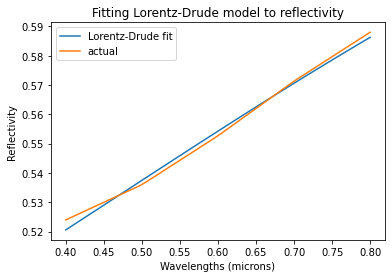

In [56]:
wavelengths = np.linspace(.4, .8)
plt.plot(wavelengths, model_reflectance(w), label='Lorentz-Drude fit')
plt.plot(wavelengths, actual_power_reflectance, label='actual')
plt.xlabel('Wavelengths (microns)')
plt.title('Fitting Lorentz-Drude model to reflectivity')
plt.ylabel('Reflectivity')
plt.legend()

In [38]:
w = np.array([ 3.34705052,  9.79423938,  8.88888959, 16.68038478, 10.        ,
        6.6666669 , 19.72565227,  0.46639302, 19.97256585, 10.        ,
       13.1138539 , 11.11111041, 10.12345656, 10.        ,  9.99542776])

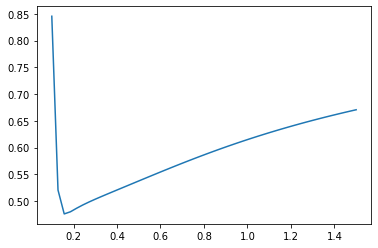

In [506]:
c = 2.998e8
hbar = 1.055e-34
e = 1.602e-19
wavelengths = np.linspace(.1, 1.5)
omega = (2*np.pi*c*hbar/(wavelengths*1e-6))/e
plt.plot(wavelengths, model_reflectance(w))

In [142]:
omega_p = 8
gamma = 1.4
eps_inf = 39
def model_reflectance(omega_p, gamma, eps_inf):
    eps = eps_inf - omega_p**2/(omega**2 + 1j*gamma)
    n = np.sqrt(eps)
    modeled_power_reflectance = np.abs((1 - n)/(1 + n))**2
    return modeled_power_reflectance


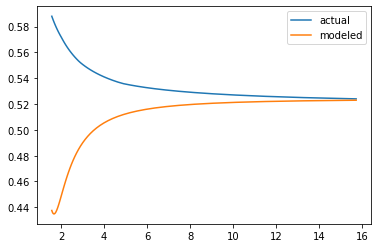

In [258]:
plt.plot(omega, actual_power_reflectance, label='actual')
plt.plot(omega, model_reflectance(omega_p, gamma, eps_inf), label='modeled')
plt.legend()

In [58]:
def eps(wvl):
    '''
    given wvl in microns, computes eps
    '''
    w = np.array([ 3.34705052,  9.79423938,  8.88888959, 16.68038478, 10.        ,
        6.6666669 , 19.72565227,  0.46639302, 19.97256585, 10.        ,
       13.1138539 , 11.11111041, 10.12345656, 10.        ,  9.99542776])
    
    c = 2.998e8
    hbar = 1.055e-34
    e = 1.602e-19
    omega = (2*np.pi*c*hbar/(wvl*1e-6))/e
    f = w[:5]
    print(f)
    omega_p = w[-1]
    omega_j = np.concatenate(([-1], w[10:14]))
    print(omega_j)
    gamma = w[5:10]
    print(gamma)
    drude_model = 1 - f[0]*omega_p**2/(omega*(omega-1j*gamma[0]))
    lorentz_result = sum([f[i]*omega_p**2/(omega_j[i]**2 - omega**2 + 1j * omega * gamma[i]) 
                     for i in range(1, len(f) - 1)])

    eps = drude_model + lorentz_result
    return eps

In [59]:
eps(.4)

[ 3.34705052  9.79423938  8.88888959 16.68038478 10.        ]
[-1.         13.1138539  11.11111041 10.12345656 10.        ]
[ 6.6666669  19.72565227  0.46639302 19.97256585 10.        ]


(20.31225020900701-23.668197037359704j)

## Compute angle-dependent emittance from Fresnel

In [60]:
def reflectivity(theta, wvl):
    n = np.sqrt(eps(wvl))
    Rs = np.abs((np.sqrt(n**2 - np.sin(theta)**2) - n**2 * np.cos(theta))
                /(np.sqrt(n**2 - np.sin(theta)**2) + n**2 * np.cos(theta)))**2
    Rp = np.abs((-np.sqrt(n**2 - np.sin(theta)**2) + np.cos(theta))
                /(np.sqrt(n**2 - np.sin(theta)**2) + np.cos(theta)))**2
    return (Rs+Rp)/2

In [61]:
def absorptivity(theta, wvl):
    return 1 - reflectivity(theta, wvl)

emissivity = absorptivity

[ 3.34705052  9.79423938  8.88888959 16.68038478 10.        ]
[-1.         13.1138539  11.11111041 10.12345656 10.        ]
[ 6.6666669  19.72565227  0.46639302 19.97256585 10.        ]


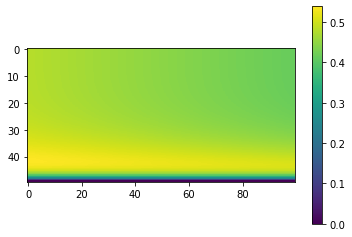

In [62]:
x = np.linspace(0, np.pi/2)
y = np.linspace(.4, .8, 100)

xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')

plt.imshow(absorptivity(xv, yv))
plt.colorbar()

[ 3.34705052  9.79423938  8.88888959 16.68038478 10.        ]
[-1.         13.1138539  11.11111041 10.12345656 10.        ]
[ 6.6666669  19.72565227  0.46639302 19.97256585 10.        ]


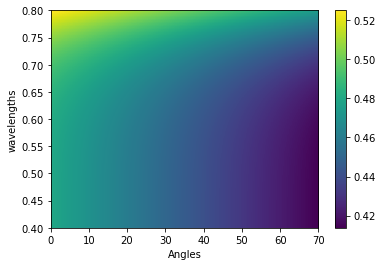

In [63]:
x = np.arange(0, 70*np.pi/180, np.pi/180)
wvls = np.linspace(.4, .8, 100)

xv, yv = np.meshgrid(x, wvls, sparse=False, indexing='ij')

plt.imshow(np.flip(absorptivity(xv, yv), axis=0), extent =[0,70,.4, .8], aspect='auto')
plt.xlabel('Angles')
plt.ylabel('wavelengths')
plt.colorbar()

In [72]:
x = np.arange(0, 70*np.pi/180, np.pi/180)
wvls = np.linspace(.4, 2.25, 100)

xv, yv = np.meshgrid(x, wvls, sparse=False, indexing='ij')
overall_emis = absorptivity(xv, yv)
overall_emis = np.swapaxes(overall_emis, 0, 1)
overall_emis.shape

[ 3.34705052  9.79423938  8.88888959 16.68038478 10.        ]
[-1.         13.1138539  11.11111041 10.12345656 10.        ]
[ 6.6666669  19.72565227  0.46639302 19.97256585 10.        ]


(100, 70)

[ 3.34705052  9.79423938  8.88888959 16.68038478 10.        ]
[-1.         13.1138539  11.11111041 10.12345656 10.        ]
[ 6.6666669  19.72565227  0.46639302 19.97256585 10.        ]


(36, 20)

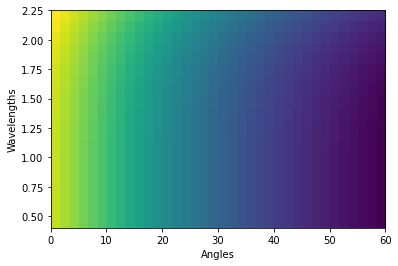

In [65]:
x = np.arange(0, 20) * 3 * np.pi/180
wvls = np.linspace(.4, 2.25, 36)

xv, yv = np.meshgrid(x, wvls, sparse=False, indexing='ij')
overall_emis = absorptivity(xv, yv)
emis_for_optimized = np.swapaxes(overall_emis, 0, 1)
plt.imshow(np.flip(emis_for_optimized.T, axis=0), aspect='auto', extent = [0,60,.4, 2.25])
plt.xlabel('Angles')
plt.ylabel('Wavelengths')
emis_for_optimized.shape

In [52]:
x = np.arange(0, 69*np.pi/180, np.pi/180)
wvls = np.linspace(.45, 2.25, 100)

xv, yv = np.meshgrid(x, wvls, sparse=False, indexing='ij')
overall_emis = absorptivity(xv, yv)
emis_for_fabricated = np.swapaxes(overall_emis, 0, 1)
#overall_emis.shape

NameError: name 'absorptivity' is not defined

## Save tungsten and planck emittance

In [188]:
with open('../adjoint_method/save_tungsten_emissivity.npy', 'wb') as f:
    np.save(f, emis_for_optimized)

In [190]:
emis_for_optimized.shape

(36, 20)

In [49]:
c = 2.998e8
hbar = 1.055e-34
h = 2*np.pi * hbar
k = 1.3807e-23
T = 3000

def planck_spectral_radiance(wvl):
    # computes power per area per wavelength of a blackbody given wvl in microns
    wvl = wvl * 1e-6
    return ((2*h*c**2 / wvl**5)
                            /(np.exp(h*c/(wvl*k*T)) - 1)) 

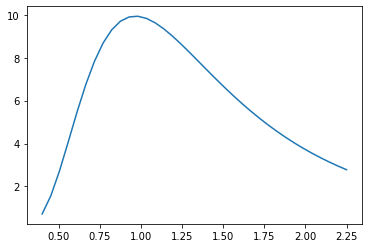

In [196]:
wvls = np.linspace(0.4, 2.25, 36)
planck_spectral_power = planck_spectral_radiance(wvls) * 1e-11
plt.plot(wvls, planck_spectral_power)

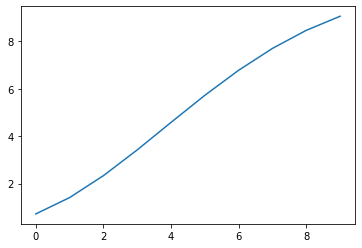

In [81]:
plt.plot(planck_spectral_power*1e-11)

In [197]:
with open('../adjoint_method/save_planck_spectral.npy', 'wb') as f:
    np.save(f, planck_spectral_power) # normalize it to not explode

In [198]:
planck_spectral_power.shape[0]

36

## Compute spectral emissive power from reflectance

In [72]:
with open('save_fabricated_reflectance.npy', 'rb') as f:
    fabricated_reflectance = np.load(f)
fabricated_reflectance.shape

(70, 100)

In [70]:

def integrate_over_hemisphere(input_array):
    '''
    input array should go be (nfreq by nangle), with the angles range from 0 to 70 degrees
    '''
    n_angles = 69
    angles = np.arange(0, n_angles)
    angles = np.reshape(angles * np.pi/180, (1, n_angles))
    scaled_array = input_array * np.sin(angles) * np.cos(angles)
    normalization = np.sin(angles)*np.cos(angles)
    return np.trapz(scaled_array, axis=1)/np.trapz(normalization, axis=1)

In [121]:
import numpy as np
fabricated_reflectance = np.swapaxes(fabricated_reflectance, 0, 1)
fabricated_spectrum = 1-integrate_over_hemisphere(fabricated_reflectance[:, :69])

In [122]:
fabricated_spectrum

array([0.51227038, 0.85798226, 0.85702382, 0.86240723, 0.85223404,
       0.83325205, 0.85100013, 0.8796658 , 0.87624281, 0.8849232 ,
       0.82379967, 0.76775841, 0.64010504, 0.52644478, 0.32362792,
       0.11263318, 0.12482048, 0.08436978, 0.09062849, 0.06781864,
       0.03238895, 0.02953896, 0.0326891 , 0.01691663, 0.01593426,
       0.02541876, 0.02706041, 0.00992948, 0.01500806, 0.02071104,
       0.03248337, 0.00898483, 0.01992992, 0.00106173, 0.00180631,
       0.0037172 , 0.00294651, 0.00586782, 0.00542049, 0.01307243,
       0.01016127, 0.01513146, 0.02143336, 0.02605546, 0.0410101 ,
       0.01425165, 0.02134539, 0.03353276, 0.05482554, 0.05292868,
       0.0150805 , 0.01644649, 0.01027086, 0.01318447, 0.01823037,
       0.02745737, 0.03235436, 0.01359909, 0.01671325, 0.02539859,
       0.01580821, 0.01914948, 0.02518015, 0.02192657, 0.02809073,
       0.03463758, 0.03933804, 0.05124608, 0.04972136, 0.04989747,
       0.06190005, 0.07811257, 0.08599346, 0.05691532, 0.04500

In [134]:
wvls_full = np.linspace(0.45, 2.25, 100)
planck_spectral_power_special = planck_spectral_radiance(wvls_full)

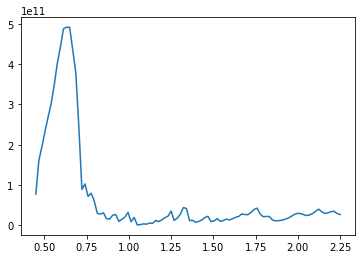

In [124]:
plt.plot(wvls_full[:], fabricated_spectrum[:] * planck_spectral_power_special[:])
#plt.plot(wvls, luminosity(wvls))

In [99]:
fabricated_spectrum[:30]

array([ 8.97080982, -1.49096153, -5.34523088, -4.04938719, -2.06362782,
       -6.53212635, -1.67906772,  2.3744596 , -1.31751796, -5.34234493,
       -2.51529105, -2.50165973, -0.40155438,  5.35823887, -0.01899733,
       -3.15519537,  3.10298915, -1.69803776, -2.03513331,  3.91577141,
       -0.17941665, -0.39867389,  2.20655809, -2.7029219 , -3.47006584,
       -0.32322868, -0.46539674,  1.05683677,  1.50863218, -0.44556788])

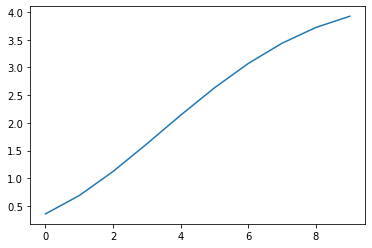

In [94]:
with open('./needle_optimized/save_optimized_stack_emissive_power.npy', 'rb') as f:
    a = np.load(f)
#a = 1e11*a/planck_spectral_radiance(np.linspace(.4, .8, 10))
plt.plot(a)

In [73]:
overall_emis_integrated = integrate_over_hemisphere(overall_emis[:, :69])
wvls_emis = np.linspace(0.4, 2.25, 100)

In [132]:
wvl_strings = ['0.4','0.4444444444444445', '0.48888888888888893', '0.5333333333333333', 
               '0.5777777777777778', '0.6222222222222222',
               '0.6666666666666667', '0.7111111111111111', '0.7555555555555555', '0.8']

reflectances = []
for i in range(69):
    single_angle_list = []
    for j in wvl_strings:
        
        with open('./needle_optimized/fluxes_'
                     +str(i) + '_' + j + '.np', 'rb') as f:
            reflectance = np.load(f)
            transmittance = np.load(f)
        print(reflectance + transmittance)
        single_angle_list.append(reflectance)
    reflectances.append(single_angle_list)

1.0010690207689519
1.0000000867400805
0.9999999279426821
0.9999999950674788
0.9999998962705083
1.0000000066572339
0.9999998722622814
0.999873021261723
1.001255792945174
0.9899798053580081
1.0006349962684948
1.0000000935606794
0.9999999051131268
0.9999999934782805
0.9999998829144507
1.0000000051298965
1.0000002738489704
1.000176095539945
1.0036783673690681
1.0101765783212748
1.0012973165120604
1.0000000586433804
0.999999895645371
0.9999999883742717
0.9999999241571981
0.9999999999984386
0.9999997947010835
1.0000042614262414
1.0035229020839695
1.0150247597027313
1.002876937862817
0.9999999373387854
0.999999884827533
0.9999999784418109
0.9999999480608213
0.9999999934045158
1.000000210871893
1.0002208465516353
0.9982237244230229
1.0790423946599677
0.9879001948815246
1.0000001316695992
0.9999998943873207
0.9999999440346751
0.9999999428861353
0.9999999868955017
0.9999993321787625
1.0004712699253822
1.0008811030405587
1.001339824811722
0.9985289969387852
1.000000363110865
0.9999999057940373
0.

In [133]:
reflectances = np.array(reflectances)
reflectances.shape


(69, 10)

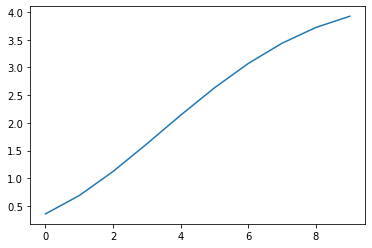

In [32]:
with open('needle_optimized/save_optimized_stack_emissive_power.npy', 'rb') as f:
    power = np.load(f)
plt.plot(power)

In [157]:
wvls_photopic = np.linspace(.4, .8, 100)

In [176]:
planck_spectral_power

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [75]:
from matplotlib.patches import Rectangle
T = 3000
#reflectances_swapped = np.swapaxes(reflectances, 0, 1)
#optimized_spectrum = 1-integrate_over_hemisphere(reflectances_swapped[:, :])
wvls = np.linspace(0.4, .8, 10)
planck_spectral_power = planck_spectral_radiance(wvls)
plt.plot(wvls[:], eff_optimized_emis[:] * planck_spectral_power[:]*1e-11/np.max(eff_optimized_emis[:] * planck_spectral_power[:]*1e-11), label="Optimized stack")
plt.plot(wvls_full[:], eff_fabricated_emis[:] * planck_spectral_power_special[:]*1e-11/np.max(eff_fabricated_emis[:] * planck_spectral_power_special[:]*1e-11), label = "Fabricated stack")
plt.plot(wvls_emis, overall_emis_integrated*planck_spectral_radiance(wvls_emis)*1e-11/np.max(overall_emis_integrated*planck_spectral_radiance(wvls_emis)*1e-11), label = "Bare emitter")
#plt.plot(wvls_photopic, luminosity(wvls_photopic)/np.max(luminosity(wvls_photopic)), label="Eye response")
plt.fill_between(wvls_photopic, luminosity(wvls_photopic)/np.max(luminosity(wvls_photopic)), 0,
                 color='purple',       # The outline color
                 alpha=0.2)
rect = Rectangle((0, 0), 1, 1, fc="purple", alpha=0.2, label = "Eye response")
plt.xlabel('Wavelength (microns)')
plt.ylabel('Spectral emissive power (scaled to unit maximum)')
plt.title('Predicted spectral emissive power (scaled)')
plt.legend()

NameError: name 'eff_optimized_emis' is not defined

In [206]:
#emis_for_optimized = integrate_over_hemisphere(emis_for_optimized)
R = 1-optimized_spectrum
T = optimized_spectrum
F = .95
eff_optimized_emis = emis_for_optimized*(F*T/(1-F**2 * R * (1-emis_for_optimized)) + (1-F)*(1+F*R)/(1 - F**2 * R * (1-emis_for_optimized)))

In [191]:
(F*T/(1-F**2 * R * (1-emis_for_optimized)) + (1-F)*(1+F*R)/(1 - F**2 * R * (1-emis_for_optimized)))

array([0.19327015, 0.20295778, 0.268452  , 0.78945056, 0.78818551,
       0.39931366, 0.19938183, 0.19552067, 0.20080545, 0.20516471])

In [192]:
eff_optimized_emis

array([0.0945241 , 0.0978021 , 0.1274281 , 0.36904503, 0.36279404,
       0.18095512, 0.08894916, 0.08587132, 0.08682647, 0.08734574])

In [186]:
optimized_spectrum

array([ 8.17800289e-03,  1.30693636e-02,  5.63421950e-02,  5.97484466e-01,
        5.91552361e-01,  1.48483720e-01,  2.76065360e-03, -1.16716954e-03,
        5.49521338e-04,  1.67438259e-03])

In [207]:
#emis_for_fabricated = integrate_over_hemisphere(emis_for_fabricated)
R = 1-fabricated_spectrum
T = fabricated_spectrum
F = .95
eff_fabricated_emis = emis_for_fabricated*(F*T/(1-F**2 * R * (1-emis_for_fabricated)) + (1-F)*(1+F*R)/(1 - F**2 * R * (1-emis_for_fabricated)))

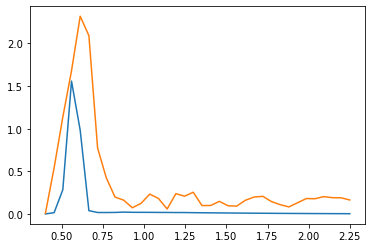

In [67]:
wvls = np.linspace(.4, 2.25, 36)

with open('needle_optimized/save_optimized_stack_emissive_power.npy', 'rb') as f:
    a = np.load(f)
with open('../adjoint_method/save_optimized_stack_emissive_power.npy', 'rb') as f:
    b = np.load(f)
plt.plot(wvls, a)
plt.plot(wvls, b)

In [87]:
np.trapz(5*b*lum_func)/np.trapz(5*b)

0.2607960637242695

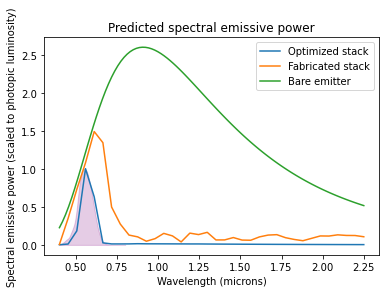

In [76]:
from matplotlib.patches import Rectangle
T = 3000
#reflectances_swapped = np.swapaxes(reflectances, 0, 1)
#optimized_spectrum = 1-integrate_over_hemisphere(reflectances_swapped[:, :])
wvls = np.linspace(0.4, 2.25, 36)
wvls_emis = np.linspace(.4, 2.25, 100)
wvls_photopic = np.linspace(.4, .8, 100)
planck_spectral_power = planck_spectral_radiance(wvls)
plt.plot(wvls[:], a/1.55, label="Optimized stack")
plt.plot(wvls[:], b/1.55, label = "Fabricated stack")
plt.plot(wvls_emis, overall_emis_integrated*planck_spectral_radiance(wvls_emis)*1e-11/1.55, label = "Bare emitter")
#plt.plot(wvls_photopic, luminosity(wvls_photopic)/np.max(luminosity(wvls_photopic)), label="Eye response")
plt.fill_between(wvls_photopic, luminosity(wvls_photopic)/np.max(luminosity(wvls_photopic)), 0,
                 color='purple',       # The outline color
                 alpha=0.2)
rect = Rectangle((0, 0), 1, 1, fc="purple", alpha=0.2, label = "Eye response")
plt.xlabel('Wavelength (microns)')
#plt.yticks([])
plt.ylabel('Spectral emissive power (scaled to photopic luminosity)')
plt.title('Predicted spectral emissive power')
plt.legend()

In [42]:
np.trapz(b*lum_func)/np.trapz(b)

0.2607960637242695

In [72]:
np.max(a)

1.5564321821825085

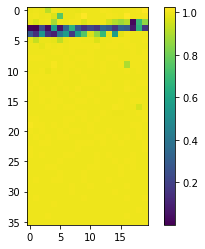

In [61]:
with open('needle_optimized/save_reflectance_spectrum.npy', 'rb') as f:
    reflectance = np.load(f)
plt.imshow(reflectance)
plt.colorbar()

In [96]:
wvls = np.linspace(.4, 2.25, 200)

In [89]:
planck_spectral_power = planck_spectral_radiance(wvls)

In [97]:
lum_func = np.array(luminosity(wvls))


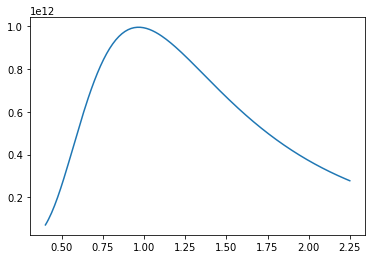

In [90]:
plt.plot(wvls, planck_spectral_power)

In [101]:
np.trapz(planck_spectral_power[1:16]*lum_func[1:16])/np.trapz(planck_spectral_power[1:16])

0.4342118691662299

In [99]:
wvls = np.linspace(0.4, 2.25, 100)
lum_func = []
for wvl in wvls:
    lum_func.append(luminosity(wvl))
lum_func = np.array(lum_func)

In [100]:
np.nonzero(lum_func> 0.01*np.max(lum_func))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),)

In [83]:
lum_func

array([3.40282802e-03, 8.43687138e-02, 4.83278131e-01, 9.92126712e-01,
       4.88990025e-01, 4.28141319e-02, 9.02523609e-04, 2.06181645e-05,
       7.20460209e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [102]:
np.trapz(lum_func**2)/np.trapz(lum_func)

0.7174791500767775

In [86]:
np.max(lum_func)

0.9921267122976895

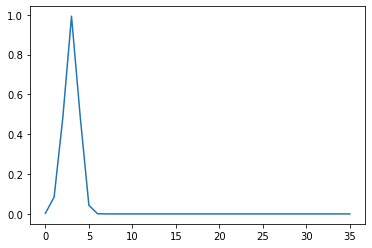

In [87]:
plt.plot(lum_func)

In [21]:
with open('../adjoint_method/save_norm_fields.npy', 'rb') as f:
    collected_ez_norm = np.load(f)

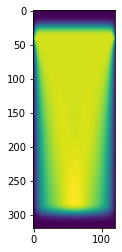

In [24]:
plt.imshow(np.abs(collected_ez_norm[:, :, 0]))

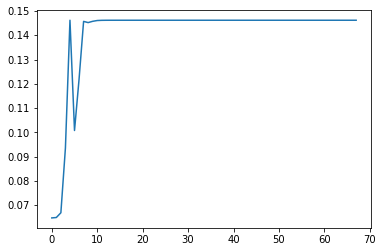

In [3]:
with open('../adjoint_method/opt_data_5_lam/save_iter_68.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    
plt.plot(a)
#plt.plot(b)

In [44]:
with open('../adjoint_method/save_5_lam_run_2_adam_iter_14.npy', 'rb') as f:
    a1 = np.load(f)
    b = np.load(f)

In [31]:
with open('../adjoint_method/save_5_lam_adam_iter_8.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)

Text(0, 0.5, 'Luminous Efficiency $\\eta$')

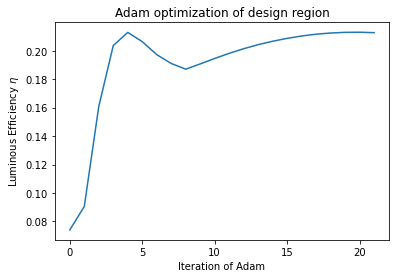

In [45]:
plt.plot(np.concatenate((a,a1)))
plt.title('Adam optimization of design region')
plt.xlabel('Iteration of Adam')
plt.ylabel('Luminous Efficiency $\eta$')

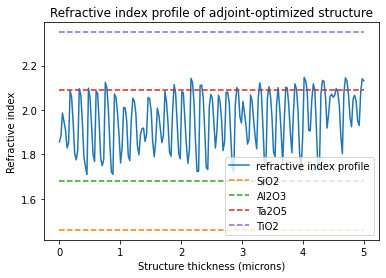

In [41]:
plt.plot(x,np.sqrt(b[200:400, 2]), label="refractive index profile")
plt.plot(x,1.46*np.ones(200), '--', label = "SiO2")
plt.plot(x,1.68*np.ones(200), '--', label = "Al2O3")
plt.plot(x,2.09*np.ones(200), '--', label = "Ta2O5")
plt.plot(x,2.35*np.ones(200), '--', label = "TiO2")

plt.title('Refractive index profile of adjoint-optimized structure')
plt.xlabel('Structure thickness (microns)')
plt.ylabel('Refractive index')
plt.legend(loc="lower right")

In [40]:
x = np.linspace(0, 5, 200)

In [ ]:
n_SiO2 = 1.46
n_Al2O3 = 1.68
n_Ta2O5 = 2.09
n_TiO2 = 2.35

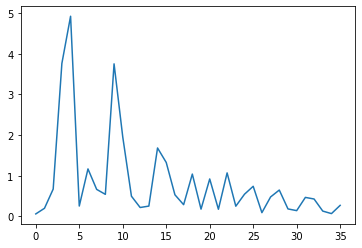

In [77]:
with open('../adjoint_method/save_adjoint_optimized_spectral_emittance.npy', 'rb') as f:
    a = np.load(f)
plt.plot(a)

In [78]:
np.max(a)

4.922869730599451

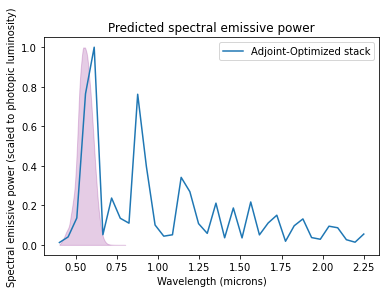

In [82]:
from matplotlib.patches import Rectangle
T = 3000
#reflectances_swapped = np.swapaxes(reflectances, 0, 1)
#optimized_spectrum = 1-integrate_over_hemisphere(reflectances_swapped[:, :])
wvls = np.linspace(0.4, 2.25, 36)
wvls_emis = np.linspace(.4, 2.25, 100)
wvls_photopic = np.linspace(.4, .8, 100)
planck_spectral_power = planck_spectral_radiance(wvls)
plt.plot(wvls[:], a/4.92, label="Adjoint-Optimized stack")
#plt.plot(wvls[:], b/1.55, label = "Fabricated stack")
#plt.plot(wvls_emis, overall_emis[:,0]*planck_spectral_radiance(wvls_emis)*1e-11/4.92, label = "Bare emitter")
#plt.plot(wvls_photopic, luminosity(wvls_photopic)/np.max(luminosity(wvls_photopic)), label="Eye response")
plt.fill_between(wvls_photopic, luminosity(wvls_photopic)/np.max(luminosity(wvls_photopic)), 0,
                 color='purple',       # The outline color
                 alpha=0.2)
rect = Rectangle((0, 0), 1, 1, fc="purple", alpha=0.2, label = "Eye response")
plt.xlabel('Wavelength (microns)')
#plt.yticks([])
plt.ylabel('Spectral emissive power (scaled to photopic luminosity)')
plt.title('Predicted spectral emissive power')
plt.legend()

In [81]:
overall_emis.shape

(100, 70)

In [83]:
np.argmax(overall_emis[:,0]*planck_spectral_radiance(wvls_emis))

27

In [84]:
wvls_emis[27]

0.9045454545454547

In [87]:
np.argmax(luminosity(wvls_photopic))

38

In [88]:
wvls_photopic[38]

0.5535353535353535

In [ ]:
wvls_pho